## Working with RDD

In this section, you will need to create RDDs from the given datasets, perform partitioning in
these RDDs and use various RDD operations to answer the queries for trip analysis.

## 1.1 Data Preparation and Loading

#### 1.1.1 Write the code to create a SparkContext object using SparkSession, which tells Spark
how to access a cluster. To create a SparkSession you first need to build a SparkConf
object that contains information about your application. Give an appropriate name for
your application and run Spark locally with as many working processors as logical cores
on your machine.
You should create a folder which is called “data”, three csv files contained in this
“data” folder. The “Assignment_1.ipynb” file should be created outside the data folder
to make the consistency for every student. See the attached image to find how to
store your data files and create your assignment_1 file.

In [1]:
# 1.1.1

# Import libraries needed from pyspark
from pyspark import SparkConf
from pyspark.sql import SparkSession  # Spark 

# Create Spark Configuration Object
master = "local[*]"
app_name = "Assignment-1"

spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# SparkSession

spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext


22/08/26 12:05:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


#### 1.1.2  Import all the “Trip” csv files into a single RDD. 

#### 1.1.4 For both Trip and Passenger, remove the header rows and display the total count and first 5 records.

In [2]:
# read a txt file

# import OS to get path of the files
import os

# trip data RDD
trip_data = sc.textFile(os.getcwd() + "/data/trip.csv")

# getting the header
header_trip = trip_data.first()

# Removing header 
trip_data = trip_data.filter(lambda row: row != header_trip)
print(f"Total partitions: {trip_data.getNumPartitions()}")
print(f"Number of lines in trip data: {trip_data.count()}")

# printing top five data
trip_data.take(5)


Total partitions: 6


Number of lines in trip data: 2318357


['a84c0db2,cb64172e,2ea4359d,43006,9/8/2019 10:01:28 PM,9/8/2019 10:15:54 PM,0.3,1.92,4.36',
 'a84c2d10,3034e6fe,e1bd0c8d,43006,7/1/2019 8:56:28 PM,7/1/2019 9:22:09 PM,0,9.36,6.91',
 'a84c3e75,93fb6802,75e6d450,43050,8/20/2019 9:30:46 PM,8/20/2019 9:46:48 PM,0,4.39,3.48',
 'a84c3f6f,25fc9273,5ba48e89,43020,9/8/2019 2:42:41 AM,9/8/2019 2:59:56 AM,0,2.04,1.54',
 'a84c5ce2,484c4d0c,fdb2ef59,43006,6/10/2019 9:29:18 AM,6/10/2019 9:55:36 AM,0,7.37,5.83']

#### 1.1.3  Import all the “Passenger” csv files into a single RDD. 

In [3]:
# passenger_data RDD
passenger_data = sc.textFile(os.getcwd() + "/data/passenger.csv")

# get the first record in RDD
header_passenger = passenger_data.first()

# removing header from the RDD
passenger_data = passenger_data.filter(lambda row: row != header_passenger)  # filter out header
print(f"Total partitions: {passenger_data.getNumPartitions()}")
print(f"Number of lines in Passenger data: {passenger_data.count()}")

# printing the top five record
passenger_data.take(5)


Total partitions: 2
Number of lines in Passenger data: 1235782


['00000fab,5/11/2019 8:23:54 PM',
 '0000149d,12/24/2018 9:21:33 PM',
 '00002b66,9/20/2018 9:08:24 PM',
 '00002bc7,7/28/2019 11:27:56 AM',
 '0000332e,2/21/2019 11:34:24 PM']

## Data Partitioning in RDD

### 
1. How many partitions do the above RDDs have? How is the data in these RDDs
partitioned by default, when we do not explicitly specify any partitioning strategy?

2. In the “Passenger” csv dataset, there is a column called first_call_time which shows the
called time of the passenger.

a. Create a Key Value Pair RDD of passenger data, with the key as 'In 2019' or
'Not In 2019' dependent on whether the first call time happened in
2019('first_call_time' column) and the rest of the other columns as the value.
After that, print the first 5 records.

b. Assume we want to keep all the data related to 2019 in one partition and keep
the other year’s data in another partition. Write the code to implement this
partitioning in RDD using appropriate partitioning functions. (Explain which
partition strategy you used?)

c. Write the code to print the number of records in each partition. 

### 1.2.1 
Above RDD has 6 partitions for trip and 2 partitions for passenger data. Default starategy when no partitioning strategy is given 

RDD partitioning <a class="anchor" id="three"></a>

By default, Spark partitions the data using <strong>Random equal partitioning</strong> unless there are specific transformations that uses a different type of partitioning</strong>


In [4]:
# 1.2.a

# function to make key value pair
def year_wise_separate(rdd):
    if rdd.split(",")[1] != "":
        if rdd.split(",")[1].split(" ")[0].split("/")[2] == "2019":
            return "In 2019", rdd
    return "Not In 2019", rdd


update_passenger_data = passenger_data.map(year_wise_separate)
update_passenger_data.take(5)


[('In 2019', '00000fab,5/11/2019 8:23:54 PM'),
 ('Not In 2019', '0000149d,12/24/2018 9:21:33 PM'),
 ('Not In 2019', '00002b66,9/20/2018 9:08:24 PM'),
 ('In 2019', '00002bc7,7/28/2019 11:27:56 AM'),
 ('In 2019', '0000332e,2/21/2019 11:34:24 PM')]

#### We are using hash function as we have to divide the data based on a condition on key In 2019 or Not in 2019

In [5]:
# 1.2.b

# making two partitions
no_of_partitions = 2


def hash_function(key):
    if key == "In 2019":
        return 2
    return 1


hash_partitioned_rdd = update_passenger_data.partitionBy(no_of_partitions, hash_function)


In [6]:
# 1.2.c
from pyspark.rdd import RDD
# function to display the partition
def print_partitions(data):
    if isinstance(data, RDD):
        numPartitions = data.getNumPartitions()
        partitions = data.glom().collect()
    else:
        numPartitions = data.rdd.getNumPartitions()
        partitions = data.rdd.glom().collect()

    print(f"####### NUMBER OF PARTITIONS: {numPartitions}")
    for index, partition in enumerate(partitions):
        # show partition if it is not empty
        if len(partition) > 0:
            print(f"Partition {index}: {len(partition)} records")


print_partitions(hash_partitioned_rdd)


####### NUMBER OF PARTITIONS: 2
Partition 0: 556856 records
Partition 1: 678926 records


## 1.3 Query/Analysis

For the Trip RDD, write relevant RDD operations to answer the following queries.
1. There are 2 columns called "trip_distance" and "surge_rate", which show the
distance and surge rate of that trip. Filter the trip RDD which if any column of them is
empty. Show the count before and after filtering.

2. Calculate the average surge rate for each city. (Hint: you can use 'city_id' directly)

3. Find the driver id who has the max and min trip distance. Also, print out all other trips
they made. (Hint: Filter the negative value of trip distance and for the driver who has
the min trip distance, only finding one driver is enough for this question)

In [7]:
# 1.3.1

# printing the count before the filtering

print("Total count in Trip csv before filtering ", trip_data.count())


# function to filter the data
def filter_data(trip):
    split_data = trip.split(",")
    if split_data[6] and split_data[7]:
        return True
    return False


# using filter transformation to filter the data
filtered_data = trip_data.filter(filter_data)

# print the count after filtering
print("Total count in Trip csv After filtering ", filtered_data.count())
filtered_data.take(5)


Total count in Trip csv before filtering  2318357


Total count in Trip csv After filtering  2295112


['a84c0db2,cb64172e,2ea4359d,43006,9/8/2019 10:01:28 PM,9/8/2019 10:15:54 PM,0.3,1.92,4.36',
 'a84c2d10,3034e6fe,e1bd0c8d,43006,7/1/2019 8:56:28 PM,7/1/2019 9:22:09 PM,0,9.36,6.91',
 'a84c3e75,93fb6802,75e6d450,43050,8/20/2019 9:30:46 PM,8/20/2019 9:46:48 PM,0,4.39,3.48',
 'a84c3f6f,25fc9273,5ba48e89,43020,9/8/2019 2:42:41 AM,9/8/2019 2:59:56 AM,0,2.04,1.54',
 'a84c5ce2,484c4d0c,fdb2ef59,43006,6/10/2019 9:29:18 AM,6/10/2019 9:55:36 AM,0,7.37,5.83']

In [8]:
# 1.3.2

# function to count the total and total surge rate
def sum_surge(a, b):
    if a[1] == "" or b[1] == "":
        a[1] = 0
        b[1] = 0
    return [a[0] + b[0], float(a[1]) + float(b[1])]


# using map creating key value pair where key is city_id and value as list of constant 1 and surge rate
# use reduceByKey to total count and total surge rate
key_count = filtered_data.map(lambda x: (x.split(",")[3], [1, x.split(",")[6]])).reduceByKey(sum_surge)

# use mapValues to calculate average 
average = key_count.mapValues(lambda x: x[1] / x[0])

# printing top 7 values
average.take(7)


[('43020', 0.03600285427063479),
 ('43050', 0.05545981386673684),
 ('43278', 0.022864212716075583),
 ('43116', 0.059504653033246084),
 ('43006', 0.03495577782547935),
 ('43179', 0.07075066034400256)]

In [9]:
# 1.3.3

# finding the max value
result_max_distance = filtered_data.max(key=lambda x: x.split(",")[7])
print("The record with maximum trip distance\n")
print(result_max_distance)

# finding the minimum value
result_min_distance = filtered_data.min(key=lambda x: x.split(",")[7])
print("The record with minimum trip distance\n")
print(result_min_distance)

print("All other trips they made are:\n")

# filtering based on id, to find all the trips made by drivers
result_trip_data = filtered_data.filter(
    lambda x: x.split(",")[1] in [result_max_distance.split(",")[1], result_min_distance.split(",")[1]])
result_trip_data.collect()


The record with maximum trip distance

7874da3e,c11c5e2b,8c69341a,43278,5/15/2019 9:33:10 PM,5/15/2019 11:18:40 PM,0,99.19,62.7


The record with minimum trip distance

aa952000,c9f9cb25,72492474,43179,5/5/2019 1:28:27 PM,5/5/2019 1:41:10 PM,0.3,-0.01,4.56
All other trips they made are:



['aa952000,c9f9cb25,72492474,43179,5/5/2019 1:28:27 PM,5/5/2019 1:41:10 PM,0.3,-0.01,4.56',
 'c7c0fb38,c9f9cb25,8ab17914,43179,6/25/2019 3:29:05 AM,6/25/2019 4:18:59 AM,0,29.33,18.44',
 'c95ccea6,c9f9cb25,8bccca37,43179,6/1/2019 9:48:54 AM,6/1/2019 9:55:32 AM,0,2.06,2.74',
 'c9e9670c,c9f9cb25,ea83cf12,43179,6/25/2019 5:05:54 AM,6/25/2019 5:19:59 AM,0,1.58,3.11',
 'e853e18e,c9f9cb25,6d4ac9a4,43179,7/9/2019 4:08:20 AM,7/9/2019 4:33:57 AM,0,9.02,3.04',
 '0b3fb3c1,c9f9cb25,6fc3504f,43179,9/7/2019 10:49:55 AM,9/7/2019 10:58:36 AM,0,1.8,1.76',
 '2a744b90,c9f9cb25,c42d7e8a,43179,9/13/2019 7:10:35 AM,9/13/2019 7:35:30 AM,0,7.48,5.24',
 '383651da,c11c5e2b,7545bdca,43278,9/20/2019 11:45:57 PM,9/21/2019 12:33:18 AM,0,22.31,14.49',
 '6ddfcaf4,c9f9cb25,774d524f,43179,8/11/2019 5:34:18 AM,8/11/2019 6:03:57 AM,0.4,4.28,4.5',
 '85ab11bb,c11c5e2b,086dac13,43278,9/17/2019 5:46:13 PM,9/17/2019 5:57:21 PM,0,2.51,3.86',
 '8b3ba126,c11c5e2b,8efcd866,43278,5/18/2019 2:07:42 AM,5/18/2019 2:20:55 AM,0,2.73,3.2

# Part 2 Working with DataFrames

## 2.1 Data Preparation and Loading

1. Load all trips, passenger, and city data into three separate dataframes. (Hint: you should
directly use “inferSchema=True”)

2. Display the schema of the final three dataframes.

In [10]:
# 2.1

# create Data frame using inferSchema to find the type of columns
trip_df = spark.read.csv(os.getcwd() + "/data/trip.csv", header=True, inferSchema=True)
passenger_df = spark.read.csv(os.getcwd() + "/data/passenger.csv", header=True, inferSchema=True)
city_df = spark.read.csv(os.getcwd() + "/data/city.csv", header=True, inferSchema=True)

# using printSchema to print the schema
trip_df.printSchema()
passenger_df.printSchema()
city_df.printSchema()


root
 |-- id: string (nullable = true)
 |-- driver_id: string (nullable = true)
 |-- passenger_id: string (nullable = true)
 |-- city_id: integer (nullable = true)
 |-- call_time: string (nullable = true)
 |-- finish_time: string (nullable = true)
 |-- surge_rate: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- trip_fare: double (nullable = true)

root
 |-- id: string (nullable = true)
 |-- first_call_time: string (nullable = true)

root
 |-- id: integer (nullable = true)
 |-- name: string (nullable = true)



## 2.2 Query/Analysis

Implement the following queries using dataframes. You need to be able to perform operations
like filtering, sorting, joining and group by using the functions provided by the DataFrame API.
The following DF means dataframes.

1. Rename ‘id’ in city DF into ‘city_id’.

2. Join city DF with trip DF. Delete 'city_id' column and rename 'name' column to 'city'
column. (Hint: You should use “inner join”)

3. Use joined DF above in 2.2.2, keep the rows in which trip_distance and trip_fare is
both larger than 0. Show 5 records after filtering.

4. Use the filtered DF above in 2.2.3, show top 5 rows using descending order of
trip_distance. (‘id’, ‘driver_id’, ‘passenger_id’ and ‘trip_distance’ should be displayed)

In [11]:
# 2.2.1

# rename the column
city_df_transformed = city_df.withColumnRenamed("id", "city_id")
city_df_transformed.show(5)


+-------+------------+
|city_id|        name|
+-------+------------+
|  42868|      Mordor|
|  42948|      Erebor|
|  43006|Minas Tirith|
|  43020|    Isengard|
|  43050|      Gondor|
+-------+------------+
only showing top 5 rows



In [12]:
# 2.2.2

# using the inner join to join the trip and city table
df_dict_inner_summ = trip_df.join(city_df_transformed, city_df_transformed.city_id == trip_df.city_id, how='inner')

# dropping the city_id col and renaming the name to city
df_dict_inner_summ_new = df_dict_inner_summ.drop('city_id').withColumnRenamed("name", "city")

# show top five data
df_dict_inner_summ_new.show(5)


+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+------------+
|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|        city|
+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+------------+
|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|Minas Tirith|
|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|Minas Tirith|
|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|      Gondor|
|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|    Isengard|
|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019 9:55:36 AM|       0.0|         7.37|     5.83|Minas Tirith|
+-------

In [13]:
# 2.2.3
from pyspark.sql.functions import col

# filtering data
df_dict_inner_summ_filtered = df_dict_inner_summ_new.filter(col("trip_distance") > 0).filter(col("trip_fare") > 0)
df_dict_inner_summ_filtered.show(5)


+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+------------+
|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|        city|
+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+------------+
|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|Minas Tirith|
|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|Minas Tirith|
|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|      Gondor|
|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|    Isengard|
|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019 9:55:36 AM|       0.0|         7.37|     5.83|Minas Tirith|
+-------

In [14]:
# 2.2.4

# filtering data and showing relevant column
df_sort = df_dict_inner_summ_filtered.sort('trip_distance', ascending=False).drop('call_time', 'finish_time',
                                                                                  'trip_fare', 'city', 'surge_rate')
df_sort.show(5)


+--------+---------+------------+-------------+
|      id|driver_id|passenger_id|trip_distance|
+--------+---------+------------+-------------+
|7f4a1ec5| 704642b5|    771e01b2|        296.1|
|30bb5f34| 7119b481|    d5e5e5d8|       261.71|
|ac1861e1| ceccad76|    2a2f3fc5|       244.82|
|4525a2bf| bdb22ca4|    b7f9f488|       236.14|
|b60c4614| 70b9733e|    09ec3959|       235.42|
+--------+---------+------------+-------------+
only showing top 5 rows



# Trip Analysis

In [15]:
# 2.3.1

from pyspark.sql.functions import udf
from pyspark.sql.types import BooleanType


# function to check if the particular day is holiday or not
def isHoliday(data):
    split_data = data.split(" ")
    dates = ['1/1/2019', '3/5/2019', '4/19/2019', '4/21/2019', '5/1/2019', '6/20/2019', '9/7/2019', '10/12/2019',
             '11/2/2019', '11/15/2019', '12/25/2019']
    return split_data[0] in dates


# Registering UDF
extract_holiday_udf = udf(isHoliday, BooleanType())

# creating On Holiday column dropping finish time for clear table view
df_trip_analysis = df_dict_inner_summ_new.withColumn("On Holiday", extract_holiday_udf(col("call_time"))).drop(
    "finish_time")
df_trip_analysis.count()
df_trip_analysis.show(5)


+--------+---------+------------+--------------------+----------+-------------+---------+------------+----------+
|      id|driver_id|passenger_id|           call_time|surge_rate|trip_distance|trip_fare|        city|On Holiday|
+--------+---------+------------+--------------------+----------+-------------+---------+------------+----------+
|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|       0.3|         1.92|     4.36|Minas Tirith|     false|
|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM|       0.0|         9.36|     6.91|Minas Tirith|     false|
|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|       0.0|         4.39|     3.48|      Gondor|     false|
|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM|       0.0|         2.04|     1.54|    Isengard|     false|
|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|       0.0|         7.37|     5.83|Minas Tirith|     false|
+--------+---------+------------+--------------------+----------+-------------+---------

In [16]:
# 2.3.2
import pyspark.sql.functions as F

# implementation one using Data frames to calculate average trip fare

agg_attribute = 'city'

# finding sum and count
df_count = df_trip_analysis.select(agg_attribute, 'On Holiday', 'trip_fare').groupby(agg_attribute, "On Holiday").agg(
    F.count(agg_attribute).alias('Total'), F.sum('trip_fare').alias('Fare Total'))
df_avg = df_count.withColumn("avg trip fare", col("Fare Total") / col("Total"))

# sorting the column based on city and On holiday
df_avg_new = df_avg.drop('Total', 'Fare Total').orderBy(['city', 'On Holiday'], ascending=True)
df_avg_new.show(15)


+------------+----------+------------------+
|        city|On Holiday|     avg trip fare|
+------------+----------+------------------+
|      Gondor|     false|  5.13122212820313|
|      Gondor|      true|5.4218031555221575|
|    Isengard|     false| 5.550994994344451|
|    Isengard|      true| 5.690277565084232|
|Minas Tirith|     false| 4.969949667768408|
|Minas Tirith|      true|  5.22092199619494|
|   Rivendell|     false| 5.669180818214374|
|   Rivendell|      true| 5.851725862931469|
|       Rohan|     false| 5.276064985963267|
|       Rohan|      true| 5.455164385996093|
|   The Shire|     false| 4.995571570029671|
|   The Shire|      true| 5.189087501615612|
+------------+----------+------------------+



In [17]:
# Second implementation using SQL

# converting DF to SQL
df_trip_analysis.createOrReplaceTempView("sql_trip_analysis")

sql_distinct_sort = spark.sql('''
  SELECT city , `On Holiday`, avg(trip_fare) as trip_fare
  FROM sql_trip_analysis
  GROUP BY city, `On Holiday`
  ORDER BY city, `On Holiday`
''')
sql_distinct_sort.show(15)


+------------+----------+------------------+
|        city|On Holiday|         trip_fare|
+------------+----------+------------------+
|      Gondor|     false|  5.13122212820313|
|      Gondor|      true|5.4218031555221575|
|    Isengard|     false| 5.550994994344451|
|    Isengard|      true| 5.690277565084232|
|Minas Tirith|     false| 4.969949667768408|
|Minas Tirith|      true|  5.22092199619494|
|   Rivendell|     false| 5.669180818214374|
|   Rivendell|      true| 5.851725862931469|
|       Rohan|     false| 5.276064985963267|
|       Rohan|      true| 5.455164385996093|
|   The Shire|     false| 4.995571570029671|
|   The Shire|      true| 5.189087501615612|
+------------+----------+------------------+



In [18]:
# 2.3.3
from pyspark.sql.functions import *
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType


# function to change date format
def day_generator(data):
    split_data = data.split(" ")
    date = split_data[0]
    return date.replace("/", "-")


# Registering UDF
extract_converter_udf = udf(day_generator, StringType())

# making temp_col to store updated date format
df_trip = df_dict_inner_summ_new.withColumn("temp_col", extract_converter_udf(col('call_time')))

# using date_format and to_date to get day of the week
df_day = df_trip.withColumn("weekday", date_format(to_date(col("temp_col"), 'M-d-yyyy'), "E")).drop("temp_col")

df_day.show(5)


+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+------------+-------+
|      id|driver_id|passenger_id|           call_time|         finish_time|surge_rate|trip_distance|trip_fare|        city|weekday|
+--------+---------+------------+--------------------+--------------------+----------+-------------+---------+------------+-------+
|a84c0db2| cb64172e|    2ea4359d|9/8/2019 10:01:28 PM|9/8/2019 10:15:54 PM|       0.3|         1.92|     4.36|Minas Tirith|    Sun|
|a84c2d10| 3034e6fe|    e1bd0c8d| 7/1/2019 8:56:28 PM| 7/1/2019 9:22:09 PM|       0.0|         9.36|     6.91|Minas Tirith|    Mon|
|a84c3e75| 93fb6802|    75e6d450|8/20/2019 9:30:46 PM|8/20/2019 9:46:48 PM|       0.0|         4.39|     3.48|      Gondor|    Tue|
|a84c3f6f| 25fc9273|    5ba48e89| 9/8/2019 2:42:41 AM| 9/8/2019 2:59:56 AM|       0.0|         2.04|     1.54|    Isengard|    Sun|
|a84c5ce2| 484c4d0c|    fdb2ef59|6/10/2019 9:29:18 AM|6/10/2019 9:55:36 AM| 

Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 186, in manager
  File "/usr/local/lib/python3.8/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/daemon.py", line 74, in worker
  File "/usr/local/lib/python3.8/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 642, in main
    if read_int(infile) == SpecialLengths.END_OF_STREAM:
  File "/usr/local/lib/python3.8/dist-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 595, in read_int
    raise EOFError
EOFError


In [19]:
# 2.3.4


agg_attribute = 'city'

# creating a temprory to store count values 
df_count_day = df_day.select(agg_attribute, 'weekday', 'trip_fare').groupby(agg_attribute, "weekday").agg(
    F.count(agg_attribute).alias('Count')).sort("city")

# counting the sum of total trips
total_count_day = df_count_day.select(agg_attribute, 'Count').groupby(agg_attribute).agg(
    F.sum('Count').alias('T-Count')).sort("city").withColumnRenamed("city", "city_new")

# joining two tables to calculate percentage
df_dict_inner_day = df_count_day.join(total_count_day, df_count.city == total_count_day.city_new,
                                      how='left').withColumn("Percentage", (col("count") / col("T-Count")) * 100).drop(
    "city_new", "T-Count").sort("city")
df_dict_inner_day.show(50)
df_dict_inner_day.count()


+------------+-------+-----+------------------+
|        city|weekday|Count|        Percentage|
+------------+-------+-----+------------------+
|      Gondor|    Tue|39995| 12.55733926951105|
|      Gondor|    Wed|40900| 12.84148458864863|
|      Gondor|    Mon|45502|14.286387084417848|
|      Gondor|    Thu|42607|13.377436035905921|
|      Gondor|    Sun|52755| 16.56363128298676|
|      Gondor|    Sat|51117|16.049343953984156|
|      Gondor|    Fri|45623|14.324377784545634|
|    Isengard|    Tue|41060|12.160593280576222|
|    Isengard|    Thu|46326|13.720205657963321|
|    Isengard|    Wed|43526|12.890939676823201|
|    Isengard|    Sun|55741|16.508612519546983|
|    Isengard|    Mon|43823| 12.97890110410842|
|    Isengard|    Fri|49305|14.602485428612047|
|    Isengard|    Sat|57867|17.138262332369806|
|Minas Tirith|    Thu|57369| 13.69531744231848|
|Minas Tirith|    Sun|67379|16.084937752897506|
|Minas Tirith|    Fri|61216|14.613686007233317|
|Minas Tirith|    Sat|69616|16.618961792

42

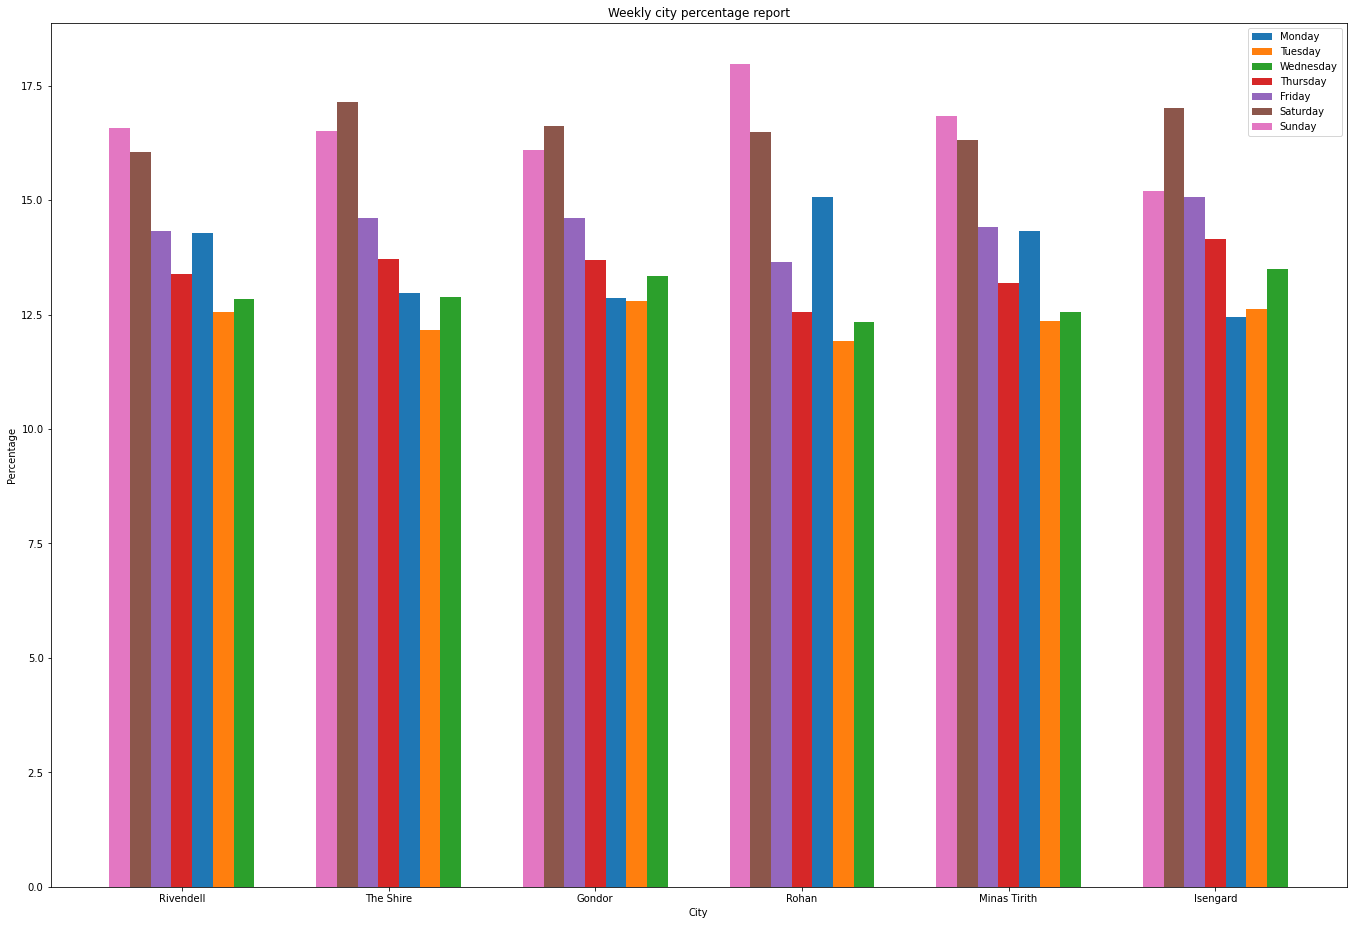

In [20]:
# 2.3.5

import matplotlib.pyplot as plt
import numpy as np

# converting Data frames to list filtering the data based on day
mon = df_dict_inner_day.select("weekday", "Percentage").filter(col("weekday") == "Mon").drop("weekday").rdd.flatMap(
    lambda x: x).collect()
tue = df_dict_inner_day.select("weekday", "Percentage").filter(col("weekday") == "Tue").drop("weekday").rdd.flatMap(
    lambda x: x).collect()
wed = df_dict_inner_day.select("weekday", "Percentage").filter(col("weekday") == "Wed").drop("weekday").rdd.flatMap(
    lambda x: x).collect()
thu = df_dict_inner_day.select("weekday", "Percentage").filter(col("weekday") == "Thu").drop("weekday").rdd.flatMap(
    lambda x: x).collect()
fri = df_dict_inner_day.select("weekday", "Percentage").filter(col("weekday") == "Fri").drop("weekday").rdd.flatMap(
    lambda x: x).collect()
sat = df_dict_inner_day.select("weekday", "Percentage").filter(col("weekday") == "Sat").drop("weekday").rdd.flatMap(
    lambda x: x).collect()
sun = df_dict_inner_day.select("weekday", "Percentage").filter(col("weekday") == "Sun").drop("weekday").rdd.flatMap(
    lambda x: x).collect()

# getting the distinct city values
city = df_dict_inner_day.select("city").distinct().rdd.flatMap(lambda x: x).collect()

# plotting barchart using matplotlib
X_axis = np.arange(len(city))

width = 0.1  # the width of the bars

fig = plt.figure()
ax = fig.add_axes([.1, .1, 3, 3])

ax.bar(X_axis + .1, mon, width, label='Monday')
ax.bar(X_axis + .2, tue, width, label='Tuesday')
ax.bar(X_axis + .3, wed, width, label='Wednesday')
ax.bar(X_axis, thu, width, label='Thursday')
ax.bar(X_axis - .1, fri, width, label='Friday')
ax.bar(X_axis - .2, sat, width, label='Saturday')
ax.bar(X_axis - .3, sun, width, label='Sunday')

ax.set_xlabel('City')
ax.set_ylabel('Percentage')
ax.set_title('Weekly city percentage report')
ax.set_xticks(X_axis, city)
ax.legend()

plt.show()


### As we can see the growth was higher on weekends compared to weekdays

## Part 3 RDDs vs DataFrame vs Spark SQL

Implement the following queries using RDDs, DataFrames and SparkSQL separately. Log the
time taken for each query in each approach using the “%%time” built-in magic command in
Jupyter Notebook and discuss the performance difference between these 3 approaches.
Note: Students could research and/or think of other ways to compare the performance of the 3
approaches rather than rely on the "%%time" command.

Query: Join the trip and city csv based on 'city_id', only keep all the data in 'Minas Tirith' city,
show id of trip, city name, and call time in the output.

In [21]:
import time

# RDD Implementation

# geting RDD from file
city_data = sc.textFile(os.getcwd() + "/data/city.csv")

# getting first row
header_city = city_data.first()

# filtering first row to remove header
city_data_new = city_data.filter(lambda row: row != header_city)

# making key value pair where key is ID
trip_data_new = trip_data.map(lambda x: (x.split(",")[3], [x.split(",")[0], x.split(",")[4]]))

# making key value pair and filtering based on city name
key_val_city = city_data.map(lambda x: (x.split(",")[0], x.split(",")[1])).filter(lambda y: y[1] == "Minas Tirith")

# using time to calcualte total time taken
t0 = time.time()
join = trip_data_new.join(key_val_city)

t1 = time.time() - t0
print("Time elapsed for RDD: ", t1)  # CPU seconds elapsed (floating point)
join.take(10)


Time elapsed for RDD:  0.02765178680419922


[('43006', (['a84c0db2', '9/8/2019 10:01:28 PM'], 'Minas Tirith')),
 ('43006', (['a84c2d10', '7/1/2019 8:56:28 PM'], 'Minas Tirith')),
 ('43006', (['a84c5ce2', '6/10/2019 9:29:18 AM'], 'Minas Tirith')),
 ('43006', (['a84ceb22', '6/30/2019 3:09:18 AM'], 'Minas Tirith')),
 ('43006', (['a84d29a0', '8/11/2019 9:49:49 PM'], 'Minas Tirith')),
 ('43006', (['a84d31ee', '7/7/2019 11:53:51 PM'], 'Minas Tirith')),
 ('43006', (['a84d8d16', '6/24/2019 7:25:16 AM'], 'Minas Tirith')),
 ('43006', (['a84dbd8a', '7/1/2019 9:56:52 PM'], 'Minas Tirith')),
 ('43006', (['a84dc20a', '6/13/2019 2:42:58 AM'], 'Minas Tirith')),
 ('43006', (['a84dfcb7', '7/27/2019 6:19:44 PM'], 'Minas Tirith'))]

In [22]:
# SQL implementation

# creating table view for SQL query
trip_df.createOrReplaceTempView("sql_trip")
city_df.createOrReplaceTempView('sql_city')

# using time to calculate time taken to run
t0 = time.time()
sql_join = spark.sql(
    """
    SELECT sql_trip.id,name,call_time
    FROM sql_city join sql_trip on sql_city.id = sql_trip.city_id
    WHERE name = "Minas Tirith"
    """)

t1 = time.time() - t0
print("Time elapsed for SQL: ", t1)  # CPU seconds elapsed (floating point)
sql_join.show(10)


Time elapsed for SQL:  0.017052173614501953
+--------+------------+--------------------+
|      id|        name|           call_time|
+--------+------------+--------------------+
|a84c0db2|Minas Tirith|9/8/2019 10:01:28 PM|
|a84c2d10|Minas Tirith| 7/1/2019 8:56:28 PM|
|a84c5ce2|Minas Tirith|6/10/2019 9:29:18 AM|
|a84ceb22|Minas Tirith|6/30/2019 3:09:18 AM|
|a84d29a0|Minas Tirith|8/11/2019 9:49:49 PM|
|a84d31ee|Minas Tirith|7/7/2019 11:53:51 PM|
|a84d8d16|Minas Tirith|6/24/2019 7:25:16 AM|
|a84dbd8a|Minas Tirith| 7/1/2019 9:56:52 PM|
|a84dc20a|Minas Tirith|6/13/2019 2:42:58 AM|
|a84dfcb7|Minas Tirith|7/27/2019 6:19:44 PM|
+--------+------------+--------------------+
only showing top 10 rows



In [23]:
# Data Frame Implementation
rename_col = city_df.withColumnRenamed("id", "temp_id")

# Using time to calculate the time taken
t0 = time.time()
df_join = trip_df.select("id", "city_id").join(rename_col, trip_df.city_id == rename_col.temp_id, how='inner').filter(
    col("name") == "Minas Tirith").drop("temp_id")
t1 = time.time() - t0

print("Time elapsed for Data frames: ", t1)  # CPU seconds elapsed (floating point)
df_join.show(10)


Time elapsed for Data frames:  0.012796640396118164
+--------+-------+------------+
|      id|city_id|        name|
+--------+-------+------------+
|a84c0db2|  43006|Minas Tirith|
|a84c2d10|  43006|Minas Tirith|
|a84c5ce2|  43006|Minas Tirith|
|a84ceb22|  43006|Minas Tirith|
|a84d29a0|  43006|Minas Tirith|
|a84d31ee|  43006|Minas Tirith|
|a84d8d16|  43006|Minas Tirith|
|a84dbd8a|  43006|Minas Tirith|
|a84dc20a|  43006|Minas Tirith|
|a84dfcb7|  43006|Minas Tirith|
+--------+-------+------------+
only showing top 10 rows



### As we can see the time taken by Data frames is faster comapared to SQL implementation and RDD, Whereas RDD implementation is the slowest. 